Claim:  The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price

Is this really the case?  Let's see what the data says

In [1]:
#import packages needed
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
#create the initial dataframe
df = pd.read_csv('../asp_original', index_col = 0)
df.head()

,documentdate,saleprice,propertytype,principaluse,saleinstrument,currentuseland,historicproperty,salereason,propertyclass,zipcode,...,waterfrontpoorqualtiy,waterfrontrestrictedaccess,waterfrontaccessrights,waterfrontproximityinfluence,tidelandshoreland,lotdepthfactopr,trafficnoise,airportnoise,powerlines,othernuisances
0,2019-04-01,1065000.0,12,6,3,N,N,1,8,98102.0,...,0,0,0,N,N,0.0,0,0,0,N
1,2019-05-04,890000.0,12,6,3,N,N,1,8,98011.0,...,0,0,0,N,N,0.0,0,1,0,N
2,2019-11-05,640000.0,11,6,3,N,N,1,8,98125.0,...,0,0,0,N,N,0.0,0,1,0,N
3,2019-01-25,645000.0,11,6,3,N,N,1,8,98028.0,...,0,0,0,N,N,0.0,0,1,0,N
4,2019-10-05,907000.0,11,6,3,N,N,1,8,98005.0,...,0,0,0,N,N,0.0,0,0,0,N


We are really only interested in the sale price of homes and the specific nuisance reported, so let's make a dataframe with only those variables

In [3]:
nuisance = df[['saleprice','airportnoise','trafficnoise','powerlines','othernuisances']]
nuisance.head()

,saleprice,airportnoise,trafficnoise,powerlines,othernuisances
0,1065000.0,0,0,0,N
1,890000.0,1,0,0,N
2,640000.0,1,0,0,N
3,645000.0,1,0,0,N
4,907000.0,0,0,0,N


In [4]:
nuisance.shape

(18182, 5)

In [5]:
nuisance.airportnoise.value_counts()

0    15679
1     1516
2      866
3      121
Name: airportnoise, dtype: int64

there is no lookup table for the airport noise feature.  Will assume that any value other than 0 indicates airport noise is present

In [6]:
nuisance.trafficnoise.value_counts()

0     18155
2         8
1         7
3         5
95        1
94        1
89        1
5         1
96        1
80        1
64        1
Name: trafficnoise, dtype: int64

like airport noise, there is no lookup table for the values.  Will assume that any value other than 0 indicates airport noise is present

In [7]:
nuisance.powerlines.value_counts()

0    18182
Name: powerlines, dtype: int64

In [8]:
nuisance.othernuisances.value_counts()

N             17976
Y               206
Name: othernuisances, dtype: int64

it looks like most nuisances reported involve airport noise.  No properties in our data set have any powerline nuisance reported and very few report traffic noise or other.  

In [9]:
nuisance[['saleprice','airportnoise','trafficnoise']].corr()

,saleprice,airportnoise,trafficnoise
saleprice,1.000000,0.005926,0.043391
airportnoise,0.005926,1.000000,-0.006557
trafficnoise,0.043391,-0.006557,1.000000


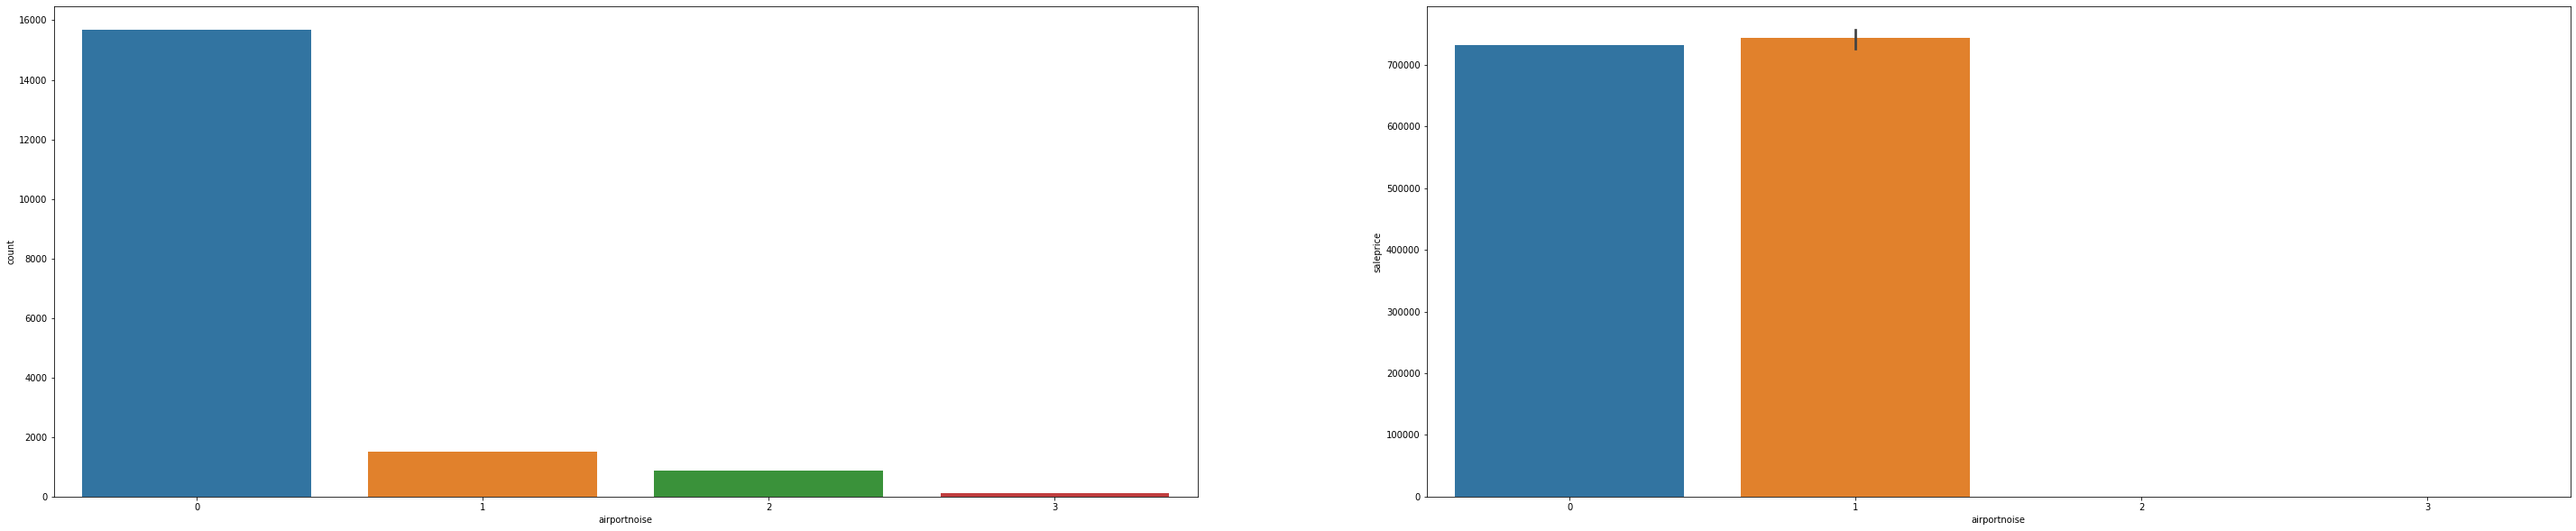

In [10]:
mean = nuisance.saleprice.groupby(nuisance['airportnoise']).mean()
airport = nuisance.airportnoise

fig, ax = plt.subplots(1,2, figsize=(50,10))
sns.countplot(airport, ax = ax[0])
sns.barplot(airport,mean, ax = ax[1]);

In [11]:
nuisance.saleprice.groupby(nuisance['airportnoise']).mean()

airportnoise
0    732090.746668
1    749544.488127
2    726925.175520
3    756889.644628
Name: saleprice, dtype: float64

Just looking at the mean sale price, there doesn't appear to be a difference.  

there are so few home sales that report traffic noise, it might be best to leave out of this analysis.  Likewise, there are no reported power nuisances and the other category is very small as well.  We will look specifically at airport noise nuisance properties and compare these to homes without a reported airport noise nuisance.

In [12]:
#create dataframe with sale price and airport noise
air = nuisance[['saleprice','airportnoise']]
air.head()

,saleprice,airportnoise
0,1065000.0,0
1,890000.0,1
2,640000.0,1
3,645000.0,1
4,907000.0,0


In [13]:
air_noise = (1,2,3)

noise = air[air.airportnoise.isin(air_noise)]
no = air[(air['airportnoise'] == 0)]

print(noise.shape)
print(no.shape)

(2503, 2)
(15679, 2)


so, is there a difference in mean sale price for homes with airport noise reported and without?  Let's check with a t-test
NULL - homes with reported airport noise have a mean sale price that is equal to or greater than homes without airport noise
Atl - homes with reported airport noise have a lower mean sale price than homes without airport noise.

We will use alpha of .05 and we are only concerned about the low-end of the distribution (one-way)

In [14]:
from scipy.stats import ttest_ind

noise = noise.saleprice
no = no.saleprice
#df is equal to n of sample 1-1 + n of sample 2 -1
df = (len(noise)-1) + (len(no)-1)
# the alpha value we are using for this test is .05
critical_tstat_below = stats.t.ppf(.05,df)
print(f'critical_t_stat_below: {critical_tstat_below}')

ttest_result = ttest_ind(no,noise, equal_var=False)
print(f'test t-stat: {ttest_result.statistic}')
print(f'pvalue: {ttest_result.pvalue}')

critical_t_stat_below: -1.644937446933295
test t-stat: -1.2295275546945568
pvalue: 0.2189618236822574


our t-test shows that there is not enough evidence to reject the NULL hypothesis.  

let's visualize what we tested.

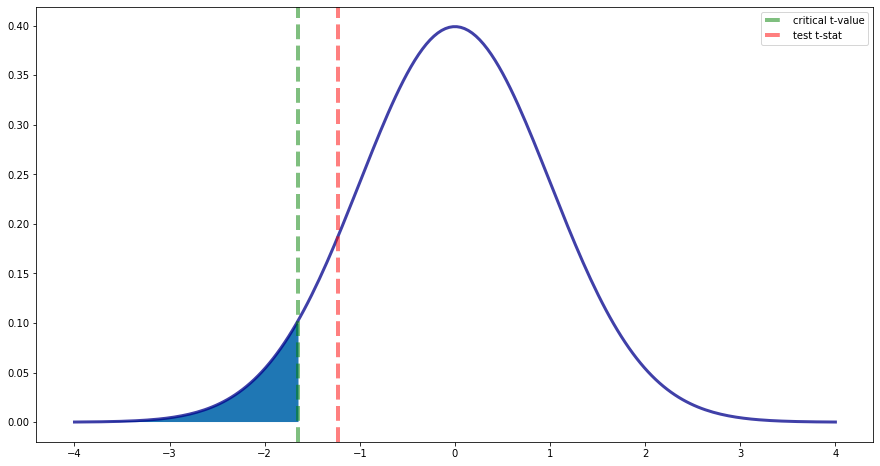

In [16]:
ttest_result = ttest_ind(no,noise, equal_var=False)

xs = np.linspace(-4, 4, 200)
# use stats.t.pdf to get values on the probability density function for the t-distribution
# the second argument is the degrees of freedom
ys = stats.t.pdf(xs, len(noise)+len(no)-2, 0, 1)
t_crit = np.round(stats.t.ppf(1 - 0.95, df=len(noise)+len(no)-2),3)

fig = plt.figure(figsize=(15,8))
ax = fig.gca()

# plot the lines using matplotlib's plot function:
ax.plot(xs, ys, linewidth=3, color='darkblue', alpha=.75)


ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value', alpha=.5)
ax.axvline(ttest_result[0],color='red',linestyle='--',lw=4,label='test t-stat', alpha=.5)
ax.legend()
ax.fill_betweenx(ys,xs,t_crit,where= xs < t_crit)
plt.show()

In [25]:
air_noise = (1,2,3)

noise = air[air.airportnoise.isin(air_noise)]
no = air[(air['airportnoise'] == 0)]

In [27]:
effect_size = Cohen_d(noise['saleprice'], no['saleprice'])
print(effect_size)

0.02707671496672959


the value of Cohen's D is very small (.03), suggesting that there is little effect on mean sale price

In [31]:
print(noise.saleprice.mean())
print(noise.saleprice.std())
print(no.saleprice.mean())
print(no.saleprice.std())

742073.6288453855
378810.34187932767
732090.7466675171
367047.73965272465


Using a calculator online, power = ~23%  https://clincalc.com/Stats/Power.aspx
using a calculator online, https://clincalc.com/Stats/SampleSize.aspx
for our results to be meaningful, we would need a much larger sample size == our noise group would need 13107 homes and our no noise group would need 82050 homes for a total of 95157 home sales.  
Mean, group 1	742073
Mean, group 2	732090
Alpha	0.05
Beta	0.2
Power	0.8
